🎯 Credit Risk Prediction with SHAP Explainability
📁 Loading German Credit Dataset...
✅ Dataset loaded successfully from UCI repository
📊 Dataset shape: (1000, 21)
📋 Features: ['checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account', 'employment_since', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence_since', 'property', 'age', 'other_installment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'telephone', 'foreign_worker', 'target']
🎯 Target distribution:
target
0    700
1    300
Name: count, dtype: int64
✅ No missing values found

🧼 Preprocessing data...
📊 Categorical columns: ['checking_account', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
📊 Numerical columns: ['duration', 'credit_amount', 'installment_rate', 'present_residence_since', 'age', 'existi

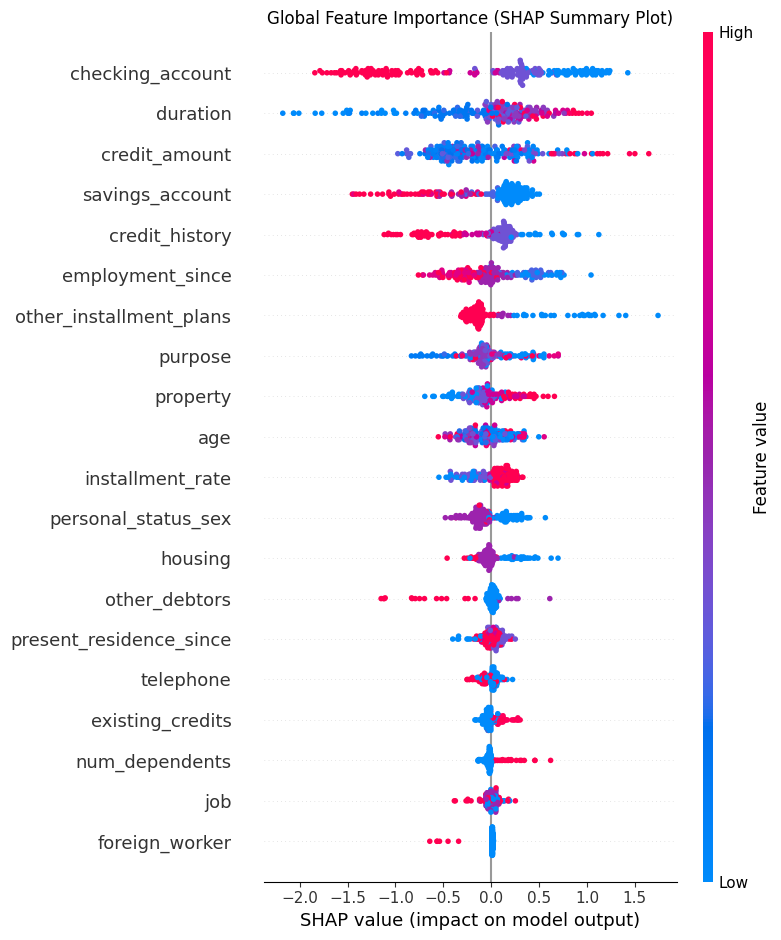

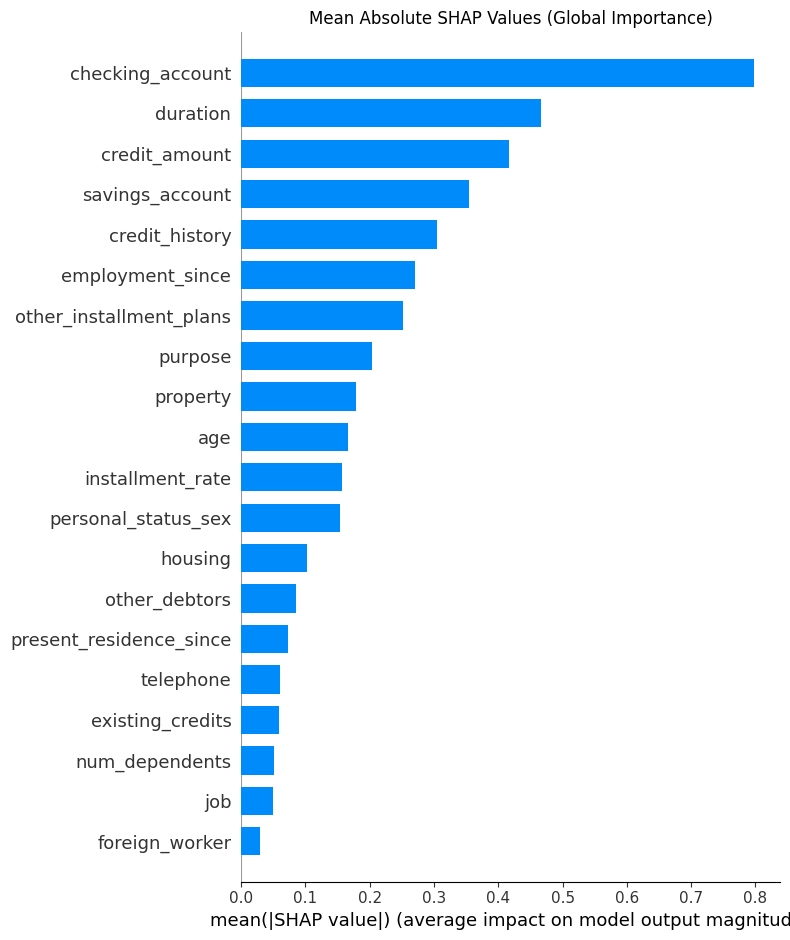


👤 Generating individual explanation for sample 0...
📋 Sample 0 details:
   Actual: Good Credit
   Predicted: Good Credit
   Confidence: 0.8380


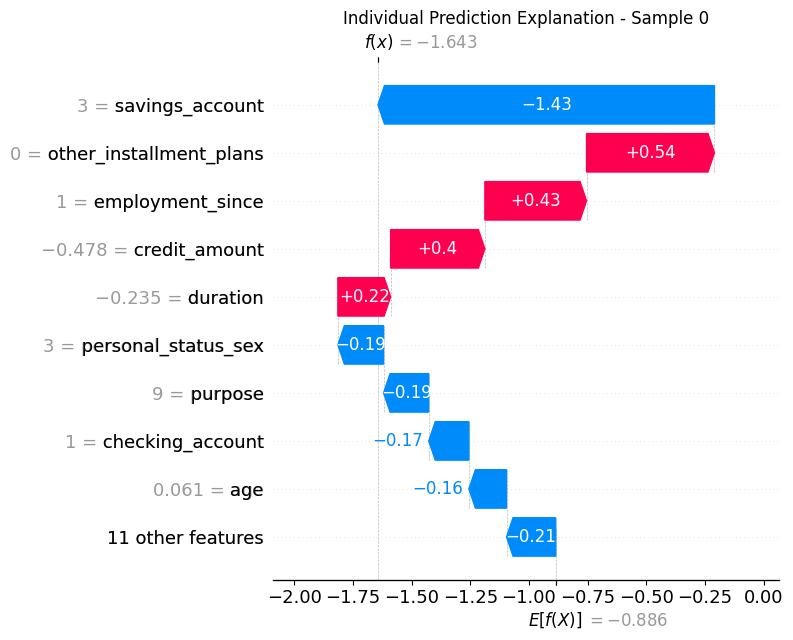

💬 Generating natural language explanation for sample 0...
📝 Natural Language Explanation:
   This loan application was approved with 83.8% confidence. The main reasons for approval are: savings_account (value: 3.0) decreases risk; other_installment_plans (value: 0.0) increases risk; employment_since (value: 1.0) increases risk.

----------------------------------------
👤 Generating individual explanation for sample 1...
📋 Sample 1 details:
   Actual: Good Credit
   Predicted: Good Credit
   Confidence: 0.8376


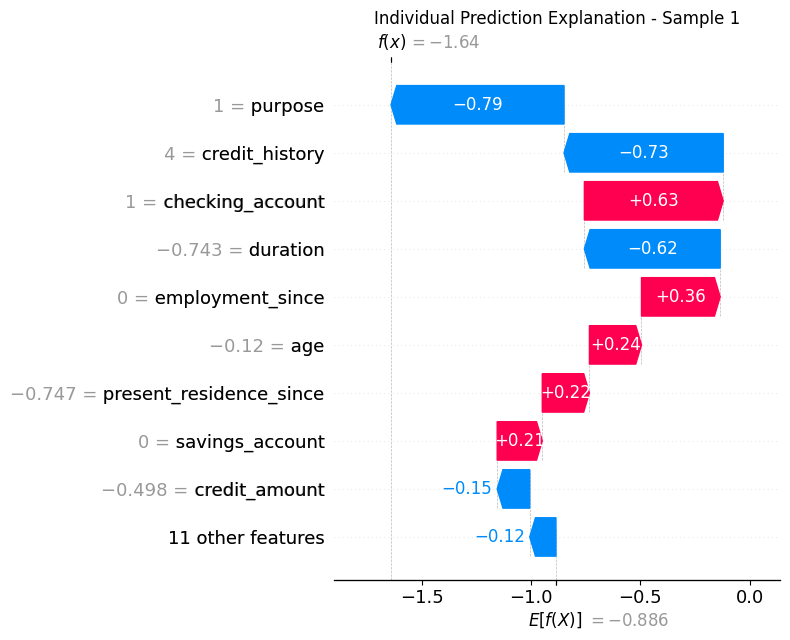

💬 Generating natural language explanation for sample 1...
📝 Natural Language Explanation:
   This loan application was approved with 83.8% confidence. The main reasons for approval are: purpose (value: 1.0) decreases risk; credit_history (value: 4.0) decreases risk; checking_account (value: 1.0) increases risk.

----------------------------------------
👤 Generating individual explanation for sample 2...
📋 Sample 2 details:
   Actual: Bad Credit
   Predicted: Bad Credit
   Confidence: 0.8970


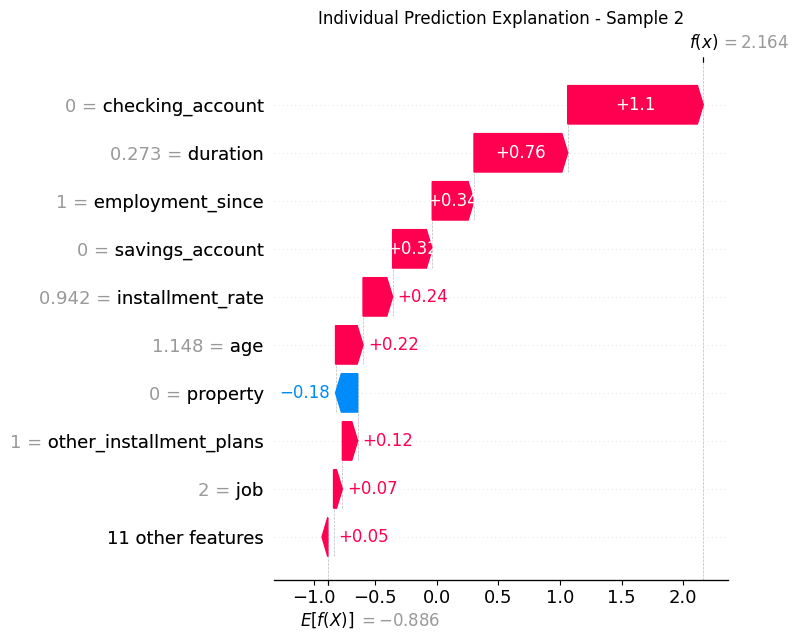

💬 Generating natural language explanation for sample 2...
📝 Natural Language Explanation:
   This loan application was denied with 89.7% confidence. The main reasons for denial are: checking_account (value: 0.0) increases risk; duration (value: 0.2734985070878224) increases risk; employment_since (value: 1.0) increases risk.

----------------------------------------

🧪 Creating Gradio interface...
🚀 Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://aa079a24b053feaf3c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import shap
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

class CreditRiskPredictor:
    def __init__(self):
        self.model = None
        self.explainer = None
        self.feature_names = None
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_and_inspect_data(self, data_path=None):
        """Load and inspect the German Credit dataset"""
        print("📁 Loading German Credit Dataset...")

        if data_path is None:
            # Load from UCI repository
            url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

            # Define column names based on UCI description
            columns = [
                'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
                'savings_account', 'employment_since', 'installment_rate', 'personal_status_sex',
                'other_debtors', 'present_residence_since', 'property', 'age', 'other_installment_plans',
                'housing', 'existing_credits', 'job', 'num_dependents', 'telephone', 'foreign_worker',
                'target'
            ]

            try:
                self.df = pd.read_csv(url, sep=' ', names=columns, header=None)
                print("✅ Dataset loaded successfully from UCI repository")
            except Exception as e:
                print(f"❌ Error loading from UCI: {e}")
                # Create sample data for demonstration
                self.df = self._create_sample_data()
                print("✅ Using sample data for demonstration")
        else:
            self.df = pd.read_csv(data_path)

        # Fix label encoding: 1=Good→0, 2=Bad→1
        self.df['target'] = self.df['target'].map({1: 0, 2: 1})  # 0=Good, 1=Bad

        print(f"📊 Dataset shape: {self.df.shape}")
        print(f"📋 Features: {self.df.columns.tolist()}")
        print(f"🎯 Target distribution:")
        print(self.df['target'].value_counts())

        # Check for missing values
        missing_values = self.df.isnull().sum()
        if missing_values.sum() > 0:
            print(f"⚠️  Missing values found:")
            print(missing_values[missing_values > 0])
        else:
            print("✅ No missing values found")

        return self.df

    def _create_sample_data(self):
        """Create sample data if UCI data is not accessible"""
        np.random.seed(42)
        n_samples = 1000

        data = {
            'checking_account': np.random.choice(['A11', 'A12', 'A13', 'A14'], n_samples),
            'duration': np.random.randint(4, 72, n_samples),
            'credit_history': np.random.choice(['A30', 'A31', 'A32', 'A33', 'A34'], n_samples),
            'purpose': np.random.choice(['A40', 'A41', 'A42', 'A43'], n_samples),
            'credit_amount': np.random.randint(250, 18424, n_samples),
            'savings_account': np.random.choice(['A61', 'A62', 'A63', 'A64', 'A65'], n_samples),
            'employment_since': np.random.choice(['A71', 'A72', 'A73', 'A74', 'A75'], n_samples),
            'installment_rate': np.random.randint(1, 5, n_samples),
            'personal_status_sex': np.random.choice(['A91', 'A92', 'A93', 'A94'], n_samples),
            'other_debtors': np.random.choice(['A101', 'A102', 'A103'], n_samples),
            'present_residence_since': np.random.randint(1, 5, n_samples),
            'property': np.random.choice(['A121', 'A122', 'A123', 'A124'], n_samples),
            'age': np.random.randint(18, 75, n_samples),
            'other_installment_plans': np.random.choice(['A141', 'A142', 'A143'], n_samples),
            'housing': np.random.choice(['A151', 'A152', 'A153'], n_samples),
            'existing_credits': np.random.randint(1, 5, n_samples),
            'job': np.random.choice(['A171', 'A172', 'A173', 'A174'], n_samples),
            'num_dependents': np.random.randint(1, 3, n_samples),
            'telephone': np.random.choice(['A191', 'A192'], n_samples),
            'foreign_worker': np.random.choice(['A201', 'A202'], n_samples),
            'target': np.random.choice([1, 2], n_samples, p=[0.7, 0.3])
        }

        return pd.DataFrame(data)

    def preprocess_data(self):
        """Preprocess the data for machine learning"""
        print("🧼 Preprocessing data...")

        # Separate features and target
        X = self.df.drop('target', axis=1)
        y = self.df['target']

        # Identify categorical and numerical columns
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

        print(f"📊 Categorical columns: {categorical_cols}")
        print(f"📊 Numerical columns: {numerical_cols}")

        # Encode categorical variables
        X_encoded = X.copy()
        for col in categorical_cols:
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X[col])
            self.label_encoders[col] = le

        # Store feature names
        self.feature_names = X_encoded.columns.tolist()

        # Train/test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_encoded, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale numerical features
        self.X_train[numerical_cols] = self.scaler.fit_transform(self.X_train[numerical_cols])
        self.X_test[numerical_cols] = self.scaler.transform(self.X_test[numerical_cols])

        print(f"✅ Training set shape: {self.X_train.shape}")
        print(f"✅ Test set shape: {self.X_test.shape}")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_model(self, model_type='xgboost'):
        """Train the classification model"""
        print(f"🤖 Training {model_type} model...")

        if model_type == 'xgboost':
            self.model = xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            )
        else:  # RandomForest
            self.model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )

        # Train the model
        self.model.fit(self.X_train, self.y_train)

        # Make predictions
        y_pred = self.model.predict(self.X_test)

        # Evaluate model
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)

        print(f"✅ Model trained successfully!")
        print(f"📊 Accuracy: {accuracy:.4f}")
        print(f"📊 Precision: {precision:.4f}")
        print(f"📊 Recall: {recall:.4f}")
        print(f"📊 F1-score: {f1:.4f}")

        return self.model

    def setup_shap_explainer(self):
        """Setup SHAP explainer for the trained model"""
        print("🔎 Setting up SHAP explainer...")

        try:
            # Use TreeExplainer for tree-based models
            self.explainer = shap.TreeExplainer(self.model)

            # Calculate SHAP values for test set
            self.shap_values = self.explainer.shap_values(self.X_test)

            # For binary classification, select the positive class SHAP values
            if len(self.shap_values) == 2:
                self.shap_values = self.shap_values[1]

            print("✅ SHAP explainer setup successfully!")

        except Exception as e:
            print(f"❌ Error setting up SHAP explainer: {e}")
            # Fallback to Explainer
            self.explainer = shap.Explainer(self.model)
            self.shap_values = self.explainer(self.X_test)
            print("✅ Fallback SHAP explainer setup successfully!")

    def generate_global_explanation(self):
        """Generate global SHAP explanations"""
        print("🌍 Generating global SHAP explanations...")

        try:
            # Summary plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(self.shap_values, self.X_test, feature_names=self.feature_names, show=False)
            plt.title('Global Feature Importance (SHAP Summary Plot)')
            plt.tight_layout()
            plt.show()

            # Bar plot of mean absolute SHAP values
            plt.figure(figsize=(10, 6))
            shap.summary_plot(self.shap_values, self.X_test, feature_names=self.feature_names,
                             plot_type="bar", show=False)
            plt.title('Mean Absolute SHAP Values (Global Importance)')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Error generating global explanation: {e}")

    def generate_individual_explanation(self, sample_idx=0):
        """Generate individual SHAP explanation for a specific sample"""
        print(f"👤 Generating individual explanation for sample {sample_idx}...")

        try:
            # Get the sample
            sample = self.X_test.iloc[sample_idx:sample_idx+1]
            actual_label = self.y_test.iloc[sample_idx]
            predicted_label = self.model.predict(sample)[0]
            predicted_proba = self.model.predict_proba(sample)[0]

            print(f"📋 Sample {sample_idx} details:")
            print(f"   Actual: {'Bad Credit' if actual_label == 1 else 'Good Credit'}")
            print(f"   Predicted: {'Bad Credit' if predicted_label == 1 else 'Good Credit'}")
            print(f"   Confidence: {predicted_proba[predicted_label]:.4f}")

            # Waterfall plot
            plt.figure(figsize=(12, 8))
            shap_values_sample = self.shap_values[sample_idx]

            # Create waterfall plot
            shap.waterfall_plot(
                shap.Explanation(
                    values=shap_values_sample,
                    base_values=self.explainer.expected_value,
                    data=sample.iloc[0].values,
                    feature_names=self.feature_names
                ),
                show=False
            )
            plt.title(f'Individual Prediction Explanation - Sample {sample_idx}')
            plt.tight_layout()
            plt.show()

            return sample_idx, actual_label, predicted_label, predicted_proba

        except Exception as e:
            print(f"❌ Error generating individual explanation: {e}")
            return None, None, None, None

    def generate_natural_language_explanation(self, sample_idx=0, top_n=3):
        """Generate human-readable explanation"""
        print(f"💬 Generating natural language explanation for sample {sample_idx}...")

        try:
            # Get SHAP values for the sample
            shap_values_sample = self.shap_values[sample_idx]
            sample = self.X_test.iloc[sample_idx]
            predicted_label = self.model.predict(sample.values.reshape(1, -1))[0]
            predicted_proba = self.model.predict_proba(sample.values.reshape(1, -1))[0]

            # Get top contributing features
            feature_contributions = list(zip(self.feature_names, shap_values_sample))
            feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

            # Generate explanation
            decision = "approved" if predicted_label == 0 else "denied"
            confidence = predicted_proba[predicted_label]

            explanation = f"This loan application was {decision} with {confidence:.1%} confidence. "

            if predicted_label == 1:  # Bad credit (denied)
                explanation += "The main reasons for denial are: "
            else:  # Good credit (approved)
                explanation += "The main reasons for approval are: "

            reasons = []
            for i, (feature, shap_value) in enumerate(feature_contributions[:top_n]):
                if abs(shap_value) > 0.001:  # Only include significant contributions
                    feature_value = sample[feature]

                    if shap_value > 0:  # Increases risk
                        impact = "increases risk"
                    else:  # Decreases risk
                        impact = "decreases risk"

                    reason = f"{feature} (value: {feature_value}) {impact}"
                    reasons.append(reason)

            explanation += "; ".join(reasons) + "."

            print(f"📝 Natural Language Explanation:")
            print(f"   {explanation}")

            return explanation

        except Exception as e:
            print(f"❌ Error generating natural language explanation: {e}")
            return "Unable to generate explanation."

    def create_gradio_interface(self):
        """Create Gradio interface for credit risk prediction"""
        print("🧪 Creating Gradio interface...")

        def predict_credit_risk(checking_account, duration, credit_history, purpose, credit_amount,
                              savings_account, employment_since, installment_rate, personal_status_sex,
                              other_debtors, present_residence_since, property_type, age,
                              other_installment_plans, housing, existing_credits, job,
                              num_dependents, telephone, foreign_worker):

            try:
                # Create input dataframe
                input_data = pd.DataFrame({
                    'checking_account': [checking_account],
                    'duration': [duration],
                    'credit_history': [credit_history],
                    'purpose': [purpose],
                    'credit_amount': [credit_amount],
                    'savings_account': [savings_account],
                    'employment_since': [employment_since],
                    'installment_rate': [installment_rate],
                    'personal_status_sex': [personal_status_sex],
                    'other_debtors': [other_debtors],
                    'present_residence_since': [present_residence_since],
                    'property': [property_type],
                    'age': [age],
                    'other_installment_plans': [other_installment_plans],
                    'housing': [housing],
                    'existing_credits': [existing_credits],
                    'job': [job],
                    'num_dependents': [num_dependents],
                    'telephone': [telephone],
                    'foreign_worker': [foreign_worker]
                })

                # Encode categorical variables
                input_encoded = input_data.copy()
                categorical_cols = input_data.select_dtypes(include=['object']).columns

                for col in categorical_cols:
                    if col in self.label_encoders:
                        # Handle unseen categories
                        if input_data[col].iloc[0] in self.label_encoders[col].classes_:
                            input_encoded[col] = self.label_encoders[col].transform(input_data[col])
                        else:
                            # Use the most common category
                            input_encoded[col] = 0

                # Scale numerical features
                numerical_cols = input_data.select_dtypes(include=['int64', 'float64']).columns
                input_encoded[numerical_cols] = self.scaler.transform(input_encoded[numerical_cols])

                # Make prediction
                prediction = self.model.predict(input_encoded)[0]
                probability = self.model.predict_proba(input_encoded)[0]

                # Generate SHAP explanation
                shap_values = self.explainer.shap_values(input_encoded)
                if len(shap_values) == 2:
                    shap_values = shap_values[1]

                # Create explanation
                decision = "APPROVED" if prediction == 0 else "DENIED"
                confidence = probability[prediction]

                # Get top contributing features
                feature_contributions = list(zip(self.feature_names, shap_values[0]))
                feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

                explanation = f"Application {decision} with {confidence:.1%} confidence.\n\n"
                explanation += "Top contributing factors:\n"

                for i, (feature, shap_value) in enumerate(feature_contributions[:5]):
                    if abs(shap_value) > 0.001:
                        impact = "↑ Increases risk" if shap_value > 0 else "↓ Decreases risk"
                        explanation += f"• {feature}: {impact} ({shap_value:.3f})\n"

                return decision, f"{confidence:.1%}", explanation

            except Exception as e:
                return "ERROR", "0%", f"Error in prediction: {str(e)}"

        # Define interface
        interface = gr.Interface(
            fn=predict_credit_risk,
            inputs=[
                gr.Dropdown(["A11", "A12", "A13", "A14"], label="Checking Account Status"),
                gr.Slider(1, 72, value=12, label="Duration (months)"),
                gr.Dropdown(["A30", "A31", "A32", "A33", "A34"], label="Credit History"),
                gr.Dropdown(["A40", "A41", "A42", "A43"], label="Purpose"),
                gr.Slider(250, 20000, value=5000, label="Credit Amount"),
                gr.Dropdown(["A61", "A62", "A63", "A64", "A65"], label="Savings Account"),
                gr.Dropdown(["A71", "A72", "A73", "A74", "A75"], label="Employment Since"),
                gr.Slider(1, 4, value=2, label="Installment Rate"),
                gr.Dropdown(["A91", "A92", "A93", "A94"], label="Personal Status & Sex"),
                gr.Dropdown(["A101", "A102", "A103"], label="Other Debtors"),
                gr.Slider(1, 4, value=2, label="Present Residence Since"),
                gr.Dropdown(["A121", "A122", "A123", "A124"], label="Property"),
                gr.Slider(18, 80, value=35, label="Age"),
                gr.Dropdown(["A141", "A142", "A143"], label="Other Installment Plans"),
                gr.Dropdown(["A151", "A152", "A153"], label="Housing"),
                gr.Slider(1, 4, value=1, label="Existing Credits"),
                gr.Dropdown(["A171", "A172", "A173", "A174"], label="Job"),
                gr.Slider(1, 2, value=1, label="Number of Dependents"),
                gr.Dropdown(["A191", "A192"], label="Telephone"),
                gr.Dropdown(["A201", "A202"], label="Foreign Worker")
            ],
            outputs=[
                gr.Textbox(label="Decision"),
                gr.Textbox(label="Confidence"),
                gr.Textbox(label="Explanation", lines=10)
            ],
            title="🏦 AI-Assisted Credit Risk Assessment",
            description="Enter applicant information to get credit risk prediction with AI explanations.",
            theme=gr.themes.Soft()
        )

        return interface

# Main execution
def main():
    """Main function to run the complete credit risk prediction pipeline"""
    print("🎯 Credit Risk Prediction with SHAP Explainability")
    print("=" * 60)

    # Initialize predictor
    predictor = CreditRiskPredictor()

    # 1. Load and inspect data
    df = predictor.load_and_inspect_data()
    print("\n" + "=" * 60)

    # 2. Preprocess data
    X_train, X_test, y_train, y_test = predictor.preprocess_data()
    print("\n" + "=" * 60)

    # 3. Train model
    model = predictor.train_model('xgboost')
    print("\n" + "=" * 60)

    # 4. Setup SHAP explainer
    predictor.setup_shap_explainer()
    print("\n" + "=" * 60)

    # 5. Generate global explanations
    predictor.generate_global_explanation()
    print("\n" + "=" * 60)

    # 6. Generate individual explanations
    for i in range(3):  # Show first 3 samples
        predictor.generate_individual_explanation(i)
        predictor.generate_natural_language_explanation(i)
        print("\n" + "-" * 40)

    print("\n" + "=" * 60)

    # 7. Create Gradio interface
    interface = predictor.create_gradio_interface()
    print("🚀 Launching Gradio interface...")

    # Launch interface
    interface.launch(share=True, debug=True)

if __name__ == "__main__":
    main()